In [2]:
from mantisshrimp.all import *

In [4]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [5]:
imgs = get_image_files(source/'PNGImages')
masks = get_image_files(source/'PedMasks')
stem2mask = {o.name.split('_')[0]: o for o in masks}

In [6]:
def get_anot(fn):
    mask = PILMaskBinary.create(stem2mask[fn.stem])
    tmask = ToTensor()(mask)
    bbox = TensorBBox.from_mask(tmask)
    labels = torch.ones(len(tmask), dtype=torch.int64) # TODO mask.masks
    iscrowd = torch.zeros((len(tmask),), dtype=torch.int64) # TODO do this inside Annotation?
    return Annotation(labels=labels, boxes=bbox, masks=mask)

In [7]:
get_anot2 = mk_transform(get_anot)

In [8]:
splits = RandomSplitter()(imgs)
dset = Datasets(imgs, [[PILImage.create], [get_anot]], dl_type=DetectDataLoader, splits=splits)

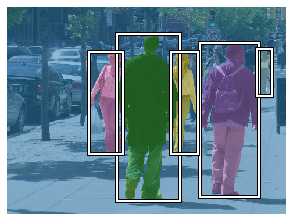

In [9]:
show_at(dset, 0)

In [10]:
# Deal with Resize and bbox locations
dls = dset.dataloaders(bs=2,
                       after_item=[ToTensor], #BBoxLabeller
                       after_batch=[IntToFloatTensor],
                      )

In [11]:
xb,yb = dls.one_batch()

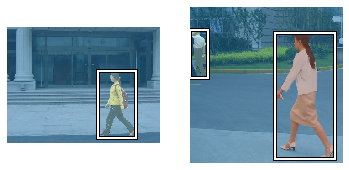

In [12]:
dls.show_batch()

In [13]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

In [14]:
learn = mask_rcnn_learner(dls, maskrcnn_resnet50_fpn, 2)

In [15]:
# learn.load('stage1');

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=3.630780702224001e-05)

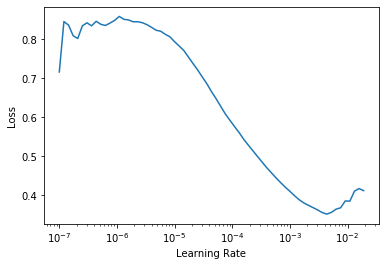

In [15]:
learn.lr_find()

In [16]:
learn.fit(1, 2.5e-4, pct_start=.9)

epoch,train_loss,valid_loss,time
0,0.067238,0.000000,01:23


In [17]:
learn.fit(4, 2.5e-4)

epoch,train_loss,valid_loss,time
0,0.047496,0.000000,00:54
1,0.044880,0.000000,00:56
2,0.040545,0.000000,00:49
3,0.038565,0.000000,00:40


In [18]:
learn.save('stage1')

In [19]:
learn.freeze_to(-2)
learn.fit(4, slice(1e-5, 1e-4))
learn.save('stage2')

epoch,train_loss,valid_loss,time
0,0.032951,0.000000,01:05
1,0.030868,0.000000,00:56
2,0.029522,0.000000,00:57
3,0.028895,0.000000,00:40


In [20]:
learn.unfreeze()
learn.fit(4, slice(5e-6, 1e-4))
learn.save('stage3')

epoch,train_loss,valid_loss,time
0,0.028193,0.000000,02:22
1,0.027192,0.000000,01:43
2,0.026890,0.000000,01:30
3,0.025638,0.000000,01:27


In [21]:
learn.inference = True
item = imgs[0]
self = learn

In [22]:
learn.inference = True
inp,targ,pred,_ = learn.predict(imgs[0], with_input=True)

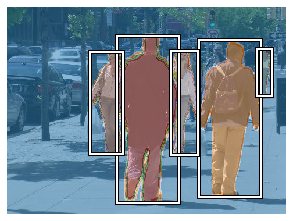

In [23]:
ax = inp.show()
pred.show(ax)

In [34]:
dl = self.dls.test_dl([item], num_workers=0)
inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
i = getattr(self.dls, 'n_inp', -1)
inp = (inp,) if i==1 else tuplify(inp)
# dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
# dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
# res = dec_targ,dec_preds[0],preds[0]
# if True: res = (dec_inp,) + res

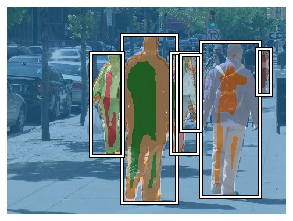

In [29]:
# Inp have only 1 channel?
ax = inp.show()
# targ.show(ax)
pred.show(ax)

## Stuff I'll use for debugging and creating test, don't worry about it

In [67]:
# Deal with Resize and bbox locations
dls = dset.dataloaders(bs=1,
                       after_item=[ToTensor], #BBoxLabeller
                       after_batch=[IntToFloatTensor],
                       num_workers=0,
                      )

In [68]:
xb,yb = dls.one_batch()
# self.dls.decode_batch(b)

In [ ]:
len(res[0]), type(res[0]), type(res[0][0])

In [90]:
len(xb), type(xb), type(xb.items), type(xb[0])

(1, mantisshrimp.data.load.Bucket, tuple, fastai2.torch_core.TensorImage)

In [95]:
xbi = inp
len(xbi), type(xbi), type(xb.items), type(xbi[0])

(1, mantisshrimp.data.load.Bucket, tuple, fastai2.torch_core.TensorImage)

In [34]:
len(yb), type(yb), type(yb.items), type(yb[0])

(2, mantisshrimp.data.load.Bucket, tuple, mantisshrimp.data.core.Annotation)

In [36]:
ybi = dec_preds
len(ybi), type(ybi), type(ybi.items), type(ybi[0])

(1, mantisshrimp.data.load.Bucket, list, mantisshrimp.data.core.Annotation)

In [ ]:
len(res[1]), type(res[1]), type(res[1].items), type(res[1][0])

In [96]:
v = (xbi, ybi)
self.dls.decode_batch(v)

(#1) [(TensorImage([[[ 45,  41,  36,  ..., 155, 158, 158],
         [ 36,  36,  36,  ..., 156, 159, 157],
         [ 30,  31,  32,  ..., 156, 160, 157],
         ...,
         [215, 216, 217,  ..., 229, 231, 235],
         [212, 214, 216,  ..., 231, 233, 236],
         [216, 217, 218,  ..., 232, 234, 235]],

        [[ 69,  65,  60,  ..., 129, 131, 131],
         [ 60,  60,  60,  ..., 130, 132, 130],
         [ 53,  54,  55,  ..., 130, 133, 131],
         ...,
         [215, 216, 217,  ..., 225, 227, 231],
         [212, 214, 216,  ..., 227, 229, 232],
         [216, 217, 218,  ..., 228, 230, 231]],

        [[ 21,  17,  12,  ..., 104, 104, 102],
         [ 12,  12,  12,  ..., 105, 103, 100],
         [  7,   8,   9,  ..., 103, 103,  98],
         ...,
         [215, 216, 217,  ..., 222, 224, 228],
         [212, 214, 216,  ..., 224, 226, 229],
         [216, 217, 218,  ..., 225, 227, 228]]], device='cuda:0'), {'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'boxes': TensorBBox(

In [67]:
type(dec_preds[0])

mantisshrimp.data.core.Annotation